<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://media.licdn.com/dms/image/C4D12AQH-T7BYWr9clg/article-inline_image-shrink_1500_2232/0?e=2120536800&v=alpha&t=RrGrsyl8QPtDQjdKKw6VpEbJrTq1Dnigk89_t9vhbfw)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually.

### Data preprocessing

In [30]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 260 ms, sys: 144 ms, total: 404 ms
Wall time: 403 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [31]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

## Preparing data

In [32]:
from subword_nmt.apply_bpe import BPE
from subword_nmt.learn_bpe import learn_bpe as learn_bpe_main
from io import StringIO
from functools import partial

def learn_bpe(captions, num_symbols=1000):
    bpe = None
    input_buf = StringIO()
    for captions_for_image in captions:
        for caption in captions_for_image:
            input_buf.write(caption)
    input_buf.seek(0)
    codes_buf = StringIO()
    learn_bpe_main(input_buf, codes_buf, num_symbols)
    codes_buf.seek(0)
    return BPE(codes_buf)

def apply_bpe(bpe, caption):
    return bpe.segment(caption)

def from_bpe_to_caption(bpe_caption):
    caption = []
    for idx, item in enumerate(bpe_caption):
        if item[-2:] == "@@":
            item = item[:-2]
        elif idx != len(bpe_caption):
            item += " "
        caption.append(item)
    return "".join(caption).split()


def prepare_captions(captions, use_bpe=False, bpe=None):
    new_captions = []
    if use_bpe and bpe is None:
        raise ValueError("No BPE provided.")
    # splitting data
    for captions_for_img in captions:
        new_captions_for_img = []
        for caption in captions_for_img:
            if use_bpe:
                split_caption = apply_bpe(bpe, caption).split()
            else:
                split_caption =  caption.split()
            new_captions_for_img.append(["#START#"] + split_caption + ["#END#"])
        new_captions.append(new_captions_for_img)
    # building vocab
    word_counts = Counter()
    for captions_for_img in new_captions:
        for caption in captions_for_img:
            word_counts.update(caption)
    vocab  = ['#UNK#', '#PAD#']
    vocab += [k for k, v in word_counts.items() if use_bpe or v >= 5]
    return vocab, np.array(new_captions)

In [34]:
USE_BPE = True # use this flag to switch between different dataset preprocessing strategies

In [35]:
from collections import Counter
from sklearn.model_selection import train_test_split
if USE_BPE:
    train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                    test_size=0.1,
                                                                                    random_state=42)
    bpe = learn_bpe(train_captions)
    vocab_train, train_captions = prepare_captions(train_captions, use_bpe=True, bpe=bpe)
    vocab_valid, val_captions = prepare_captions(val_captions, use_bpe=True, bpe=bpe)
    vocab = list(set(vocab_train) & set(vocab_valid))
else:
    vocab, captions = prepare_captions(captions) 
    train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                    test_size=0.1,
                                                                                    random_state=42)
word_to_index = {vocab[idx]: idx for idx in range(len(vocab))}
n_tokens = len(vocab)
pad_ix = word_to_index['#PAD#']

In [36]:
def batch_captions(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    unk_ix = word_to_index['#UNK#']
    max_len = max_len or max(map(len,sequences))
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [37]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [38]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256,
                 cnn_feature_size=2048, num_lstm_layers=5, concat_img_features_with_lstm_state=True):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super().__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=pad_ix)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        if concat_img_features_with_lstm_state:
            lstm_input_size = emb_size + cnn_feature_size
        else:
            lstm_input_size = emb_size
        self.lstm = nn.LSTM(lstm_input_size, lstm_units,
                            num_lstm_layers, batch_first=True)
        self.num_lstm_layers = num_lstm_layers
        self.concat_img_features_with_lstm_state = concat_img_features_with_lstm_state
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix, prev_internal_state=None):
        """ 
        Apply the network in training mode. 
        :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        initial_internal_state = (initial_cell[None].repeat(self.num_lstm_layers, 1, 1),
                                  initial_hid[None].repeat(self.num_lstm_layers, 1, 1))
        if prev_internal_state is None:
            prev_internal_state = initial_internal_state
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
#         if image_vectors.shape[0] != captions_ix.shape[0]:
#             print(captions_emb.shape)
#             print(image_vectors.shape)
#         print(torch.cat((captions_emb,
#                          image_vectors[None].transpose(1, 0).repeat(1, captions_emb.shape[1], 1)), dim=2).shape)
        if self.concat_img_features_with_lstm_state:
            captions_emb = torch.cat((captions_emb,
                             image_vectors[None].transpose(1, 0).repeat(1, captions_emb.shape[1], 1)), dim=2)
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg
        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, internal_state = self.lstm(captions_emb, prev_internal_state)
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits, internal_state     

In [39]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float Variable
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next, _ = network(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by 
    # or by using ignore_index in some losses.
    mask = (captions_ix_next != pad_ix)
    seq_lengths = torch.sum(mask, dim=1).float()
    loss = torch.mean(torch.sum(F.nll_loss(input=F.log_softmax(logits_for_next, dim=2).transpose(2, 1),
                                target=captions_ix_next) * mask.float(), dim=1) / seq_lengths)
    return loss

In [40]:
from nltk.translate.bleu_score import corpus_bleu

def compute_bleu(model, image_vectors_batch, reference_captions, max_len=100, use_cuda=True):
    prefix = batch_captions([["#START#"] for _ in range(len(image_vectors_batch))])
    hyp_captions_batch = [[word_to_index["#START#"]] for _ in range(len(image_vectors_batch))]
    prefix = Variable(torch.LongTensor(prefix), volatile=True)
    if use_cuda:
        prefix = prefix.cuda()
    prev_internal_state=None
    if use_cuda:
        prefix = prefix.cuda()
    for _ in range(max_len):
        next_word_logits, prev_internal_state = model(image_vectors_batch, prefix, prev_internal_state)
        next_word_probs = F.softmax(next_word_logits, -1)
        next_words = torch.max(next_word_probs, dim=2)[1]
        prefix = next_words
        next_words = next_words.data.cpu().numpy()
        for i in range(len(hyp_captions_batch)):
            hyp_captions_batch[i].append(next_words[i][0])

        if (next_words == word_to_index["#END#"]).all():
            break
    hyp_captions_without_padding = []
    for caption_indices in hyp_captions_batch:
        caption = np.array(list(map(lambda x: vocab[x], caption_indices)))
        caption = caption[caption != "#PAD#"]
        caption = list(caption[caption != "#END#"])
        caption.append("#END#")
        if USE_BPE:
            caption = from_bpe_to_caption(caption)
        hyp_captions_without_padding.append(caption)
    if USE_BPE:
        num_imgs = len(reference_captions)
        for img_idx in range(num_imgs):
            for caption_idx in range(len(reference_captions[img_idx])):
                reference_captions[img_idx][caption_idx] = from_bpe_to_caption(reference_captions[img_idx][caption_idx])
    return corpus_bleu(reference_captions, hyp_captions_without_padding)

In [41]:
network = CaptionNet(n_tokens)
dummy_img_vec = Variable(torch.randn(len(captions[0]), 2048))
dummy_capt_ix = Variable(torch.LongTensor(batch_captions(captions[0])))

dummy_logits, _ = network(dummy_img_vec, dummy_capt_ix)
print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

shape: torch.Size([5, 76, 1078])


Create ~~adam~~ your favorite optimizer for the network.

# Training

* First implement the batch generator
* Than train the network as usual

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [42]:
from tqdm import tqdm_notebook as tqdm
import random
from copy import deepcopy

def iterate_minibatches(img_codes, all_captions, batch_size, return_original_captions=False, use_cuda=True):
    permutation = np.random.permutation(img_codes.shape[0])
    img_codes = img_codes[permutation]
    all_captions = all_captions[permutation]
    for idx in range(0, len(img_codes), batch_size):
        img_batch = img_codes[idx:idx + batch_size]    
        #5-7 captions for each image
        captions_for_batch_images = all_captions[idx:idx + batch_size]   
        #pick one from a set of captions for each image
        captions_batch = list(map(random.choice,captions_for_batch_images))
        #convert to matrix
        batch_captions_ix = batch_captions(captions_batch)
        batch_imgs_variable = Variable(torch.FloatTensor(img_batch))
        batch_captions_variable = Variable(torch.LongTensor(batch_captions_ix))
        if use_cuda:
            batch_imgs_variable = batch_imgs_variable.cuda()
            batch_captions_variable = batch_captions_variable.cuda()
        if return_original_captions:
            yield batch_imgs_variable, batch_captions_variable, captions_for_batch_images
        else:
            yield batch_imgs_variable, batch_captions_variable

def num_iters(dataset_length, batch_size):
    num_iters_ = dataset_length // batch_size
    if dataset_length % batch_size != 0:
        num_iters_ += 1
    return num_iters_

def train(model, optimizer, n_epochs, batch_size, use_cuda=True, early_stopping_iters=15):
    if use_cuda:
        model = model.cuda()
    all_train_losses = []
    all_val_losses = []
    all_val_bleu = []
    total_train = num_iters(len(train_img_codes), batch_size)
    total_val = num_iters(len(val_img_codes), batch_size)
    best_on_val_state_dict = None
    best_val_bleu = None
    num_iters_ = 0
    for epoch in range(n_epochs):

        train_losses = []
        model.train(True)
        for img_train_batch, captions_train_batch in tqdm(iterate_minibatches(train_img_codes,
                                                                              train_captions,
                                                                              batch_size,
                                                                              use_cuda=use_cuda),
                                                          total=total_train):
            loss_t = compute_loss(model, img_train_batch, captions_train_batch)
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()
            train_losses.append(loss_t.data.cpu().numpy()[0])

        avg_train_loss = np.mean(train_losses)
        all_train_losses.append(avg_train_loss)
        val_losses=[]
        model.train(False)
        val_bleu = []
        for img_val_batch, captions_val_batch, original_val_captions in tqdm(iterate_minibatches(val_img_codes,
                                                                             val_captions,
                                                                             batch_size,
                                                                             return_original_captions=True,
                                                                             use_cuda=use_cuda),
                                                                             total=total_val):
            loss_t = compute_loss(model, img_val_batch, captions_val_batch)
            bleu = compute_bleu(model, img_val_batch, original_val_captions)
            val_losses.append(loss_t.data.cpu().numpy()[0])
            val_bleu.append(bleu)
        avg_val_loss = np.mean(val_losses)
        avg_val_bleu = np.mean(val_bleu)
        all_val_losses.append(avg_val_loss)
        all_val_bleu.append(avg_val_bleu)
        if best_val_bleu is None or avg_val_bleu > best_val_bleu:
            num_iters_ = 0
            best_val_bleu = avg_val_bleu
            best_on_val_state_dict = deepcopy(model.state_dict())
        
        print('\nEpoch: {}, train loss: {}, val loss: {}, val_bleu: {}'.format(epoch, avg_train_loss, avg_val_loss, avg_val_bleu))
        if num_iters_ > early_stopping_iters:
            break
        num_iters_ += 1
    print("Finished!")
    return all_train_losses, all_val_losses, all_val_bleu, best_on_val_state_dict

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [15]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False).cuda()

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [16]:
import tempfile
import os
from matplotlib import pyplot as plt
from scipy.misc import imresize
from skimage import transform, io
%matplotlib inline

def center_crop(image):
    length = min(image.shape[0], image.shape[1])
    upper_left_corner_x = image.shape[1] // 2 - length // 2
    upper_left_corner_y = image.shape[0] // 2 - length // 2
    new_image = image[upper_left_corner_y:upper_left_corner_y + length, upper_left_corner_x: upper_left_corner_x + length]
    return new_image
    
def generate_captions(image_path=None, image_url=None, num_captions=1, caption_prefix = ("START",),
                      t=1, sample=True, max_len=100, use_cuda=True):
    global inception
    if image_path is not None:
        image = io.imread(image_path)
    elif image_url is not None:
        with tempfile.NamedTemporaryFile() as img_file:
            ! wget {image_url} -O {img_file.name} 1>/dev/null 2>/dev/null
            image = io.imread(img_file)
    else:
        raise ValueError("Image source is not provided.")
    if use_cuda:
        inception = inception.cuda()
    # image = center_crop(image)
    image = transform.resize(image.astype("float32") / 255., (299, 299), mode="reflect").astype('float32') 
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    plt.imshow(image)
    plt.show()
    image = Variable(torch.FloatTensor(image.transpose([2, 0, 1])), volatile=True).cuda()
    
    for _ in range(num_captions):
        caption = list(caption_prefix)
        vectors_8x8, vectors_neck, logits = inception(image[None])
        for _ in range(max_len):
            prefix_ix = batch_captions([caption])
            prefix_ix = Variable(torch.LongTensor(prefix_ix), volatile=True).cuda()
            logits, _ = network.forward(vectors_neck, prefix_ix)
            next_word_logits = logits[0, -1]
            next_word_probs = F.softmax(next_word_logits, -1).data.cpu().numpy()


            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption.append(next_word)

            if next_word=="#END#":
                break
        if USE_BPE:
            caption = from_bpe_to_caption(caption)
        yield " ".join(caption[1:-1])

def show_sample_captions(image_path=None, image_url=None, num_captions=10):
    for caption in generate_captions(image_path=image_path, image_url=image_url, num_captions=num_captions, t=5.):
        print(caption)

In [17]:
from IPython import display
def plot_metrics(all_metrics, subplots_layout=(1, 2), 
                 figsize=(20, 10), log_scale=False):
    display.clear_output(wait=True)
    fig, axes = plt.subplots(*subplots_layout, figsize=figsize)
    fig.subplots_adjust(hspace=100)
    if log_scale:
        plt.yscale('log')
    width = axes.shape[0]
    height = 1
    if len(axes.shape) > 1:
        height = axes.shape[1]
    for idx, title in enumerate(all_metrics):
        i = idx // width
        j = idx % width
        for label in all_metrics[title]:
            metric_values = all_metrics[title][label]
            if len(axes.shape) > 1:
                ax = axes[i, j]
            else:
                ax = axes[j]
            ax.set(title=title, ylabel=title.lower(), xlabel="#iteration")
            ax.plot(metric_values, label=label)
            ax.legend()
    plt.show()

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of the assignment. Go get at least 10 pictures to get captioned.
* Make sure it works okay on __simple__ images before going to something more complex.
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime.
* Mind the aspect ratio

# Experiments

## 5-layer LSTM with better train dataset coverage and early stopping

In [18]:
batch_size = 256  # adjust me
n_epochs = 100  # adjust me
network = CaptionNet(n_tokens, concat_img_features_with_lstm_state=False)
lr = 0.001
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
train_losses, val_losses, val_bleu, best_on_val_state_dict =  train(network, optimizer, n_epochs, batch_size) 



Epoch: 0, train loss: 2.4739887714385986, val loss: 2.2971079349517822, val_bleu: 0.07161292527086185




Epoch: 1, train loss: 1.930572748184204, val loss: 1.6559613943099976, val_bleu: 0.19925769647681735




Epoch: 2, train loss: 1.5560969114303589, val loss: 1.5359269380569458, val_bleu: 0.2257258236413217




Epoch: 3, train loss: 1.4474759101867676, val loss: 1.4060897827148438, val_bleu: 0.2341808876493638




Epoch: 4, train loss: 1.3785359859466553, val loss: 1.4172254800796509, val_bleu: 0.23465139286396244




Epoch: 5, train loss: 1.3442047834396362, val loss: 1.3096511363983154, val_bleu: 0.260030832148722




Epoch: 6, train loss: 1.291401982307434, val loss: 1.324029564857483, val_bleu: 0.2638919376558292




Epoch: 7, train loss: 1.2716542482376099, val loss: 1.285597801208496, val_bleu: 0.25412605668030563




Epoch: 8, train loss: 1.2307287454605103, val loss: 1.2997630834579468, val_bleu: 0.2723257354650682




Epoch: 9, train loss: 1.214269757270813, val loss: 1.2512755393981934, val_bleu: 0.2627476984566999




Epoch: 10, train loss: 1.1980030536651611, val loss: 1.2179235219955444, val_bleu: 0.27115886291224195




Epoch: 11, train loss: 1.1664237976074219, val loss: 1.205012321472168, val_bleu: 0.2652833330787324




Epoch: 12, train loss: 1.1684495210647583, val loss: 1.1511768102645874, val_bleu: 0.27723584571818954




Epoch: 13, train loss: 1.1302309036254883, val loss: 1.2178395986557007, val_bleu: 0.27258484736049476




Epoch: 14, train loss: 1.1299567222595215, val loss: 1.2644131183624268, val_bleu: 0.27141713142300306




Epoch: 15, train loss: 1.1386330127716064, val loss: 1.1802337169647217, val_bleu: 0.2707630469647651




Epoch: 16, train loss: 1.1155879497528076, val loss: 1.1687389612197876, val_bleu: 0.26892793152748684




Epoch: 17, train loss: 1.1131434440612793, val loss: 1.131820559501648, val_bleu: 0.2761103254873692




Epoch: 18, train loss: 1.0956543684005737, val loss: 1.1906943321228027, val_bleu: 0.27660130084494705




Epoch: 19, train loss: 1.1139308214187622, val loss: 1.1332995891571045, val_bleu: 0.2760407230955973




Epoch: 20, train loss: 1.0969358682632446, val loss: 1.1515305042266846, val_bleu: 0.2763522469620049




Epoch: 21, train loss: 1.0859003067016602, val loss: 1.19098961353302, val_bleu: 0.27650930447181843




Epoch: 22, train loss: 1.0943173170089722, val loss: 1.1232510805130005, val_bleu: 0.27346434098233907




Epoch: 23, train loss: 1.0818262100219727, val loss: 1.1610491275787354, val_bleu: 0.2741461936748521




Epoch: 24, train loss: 1.0657089948654175, val loss: 1.1316148042678833, val_bleu: 0.28221492807886267




Epoch: 25, train loss: 1.0652941465377808, val loss: 1.1136776208877563, val_bleu: 0.27662847151137526




Epoch: 26, train loss: 1.0279165506362915, val loss: 1.1410881280899048, val_bleu: 0.28220033408357287




Epoch: 27, train loss: 1.049042820930481, val loss: 1.099204421043396, val_bleu: 0.2761129404264771




Epoch: 28, train loss: 1.0594099760055542, val loss: 1.1077700853347778, val_bleu: 0.28126295570500515




Epoch: 29, train loss: 1.032261610031128, val loss: 1.091746211051941, val_bleu: 0.27700298589121325




Epoch: 30, train loss: 1.0413798093795776, val loss: 1.0680524110794067, val_bleu: 0.2768131454157263




Epoch: 31, train loss: 1.0459721088409424, val loss: 1.1293728351593018, val_bleu: 0.2864077638985794




Epoch: 32, train loss: 1.0319921970367432, val loss: 1.1294000148773193, val_bleu: 0.28693783498090897




Epoch: 33, train loss: 1.0176540613174438, val loss: 1.1072547435760498, val_bleu: 0.28058751553842004




Epoch: 34, train loss: 1.0230281352996826, val loss: 1.1040033102035522, val_bleu: 0.28412528869440606




Epoch: 35, train loss: 1.0160465240478516, val loss: 1.0952670574188232, val_bleu: 0.27742600393048195




Epoch: 36, train loss: 1.018802523612976, val loss: 1.1275447607040405, val_bleu: 0.28244248267733635




Epoch: 37, train loss: 1.0268770456314087, val loss: 1.1324354410171509, val_bleu: 0.2812132327002702




Epoch: 38, train loss: 1.0174634456634521, val loss: 1.095285177230835, val_bleu: 0.28100942031385107




Epoch: 39, train loss: 1.0102063417434692, val loss: 1.1560547351837158, val_bleu: 0.28742918899953757




Epoch: 40, train loss: 1.0076563358306885, val loss: 1.1312836408615112, val_bleu: 0.2768739152738904




Epoch: 41, train loss: 1.000233769416809, val loss: 1.0844545364379883, val_bleu: 0.285075661491543




Epoch: 42, train loss: 0.985930323600769, val loss: 1.1227601766586304, val_bleu: 0.2831964423101966




Epoch: 43, train loss: 1.0020939111709595, val loss: 1.1207469701766968, val_bleu: 0.2799539659232567




Epoch: 44, train loss: 0.9935440421104431, val loss: 1.111946940422058, val_bleu: 0.28645663513891234




Epoch: 45, train loss: 0.9783359169960022, val loss: 1.124023675918579, val_bleu: 0.2887063240073793




Epoch: 46, train loss: 0.9979134798049927, val loss: 1.1802009344100952, val_bleu: 0.2800250286523319




Epoch: 47, train loss: 0.9857164621353149, val loss: 1.1009629964828491, val_bleu: 0.2805651541436501




Epoch: 48, train loss: 1.0000687837600708, val loss: 1.1467304229736328, val_bleu: 0.2836659252597095




Epoch: 49, train loss: 0.9991324543952942, val loss: 1.079795002937317, val_bleu: 0.288233987002746




Epoch: 50, train loss: 0.9858719706535339, val loss: 1.0747871398925781, val_bleu: 0.2859285416032317




Epoch: 51, train loss: 0.9822148680686951, val loss: 1.0891203880310059, val_bleu: 0.28025682328510987




Epoch: 52, train loss: 0.9836056232452393, val loss: 1.14115571975708, val_bleu: 0.2857950111107799




Epoch: 53, train loss: 0.9741464257240295, val loss: 1.1002503633499146, val_bleu: 0.28582534343997457




Epoch: 54, train loss: 0.9720765352249146, val loss: 1.1025911569595337, val_bleu: 0.2851533021581077




Epoch: 55, train loss: 0.9770742654800415, val loss: 1.070882797241211, val_bleu: 0.28583798299596697




Epoch: 56, train loss: 0.9618512392044067, val loss: 1.075405240058899, val_bleu: 0.2855435092278869




Epoch: 57, train loss: 0.9646942615509033, val loss: 1.124885082244873, val_bleu: 0.2775968335469734




Epoch: 58, train loss: 0.9816946387290955, val loss: 1.1163591146469116, val_bleu: 0.28339075219680016




Epoch: 59, train loss: 0.9661597013473511, val loss: 1.1411305665969849, val_bleu: 0.286481397231399




Epoch: 60, train loss: 0.9675253629684448, val loss: 1.1242488622665405, val_bleu: 0.28185707052302666




Epoch: 61, train loss: 0.9546788930892944, val loss: 1.1441147327423096, val_bleu: 0.2860490939046254
Finished!


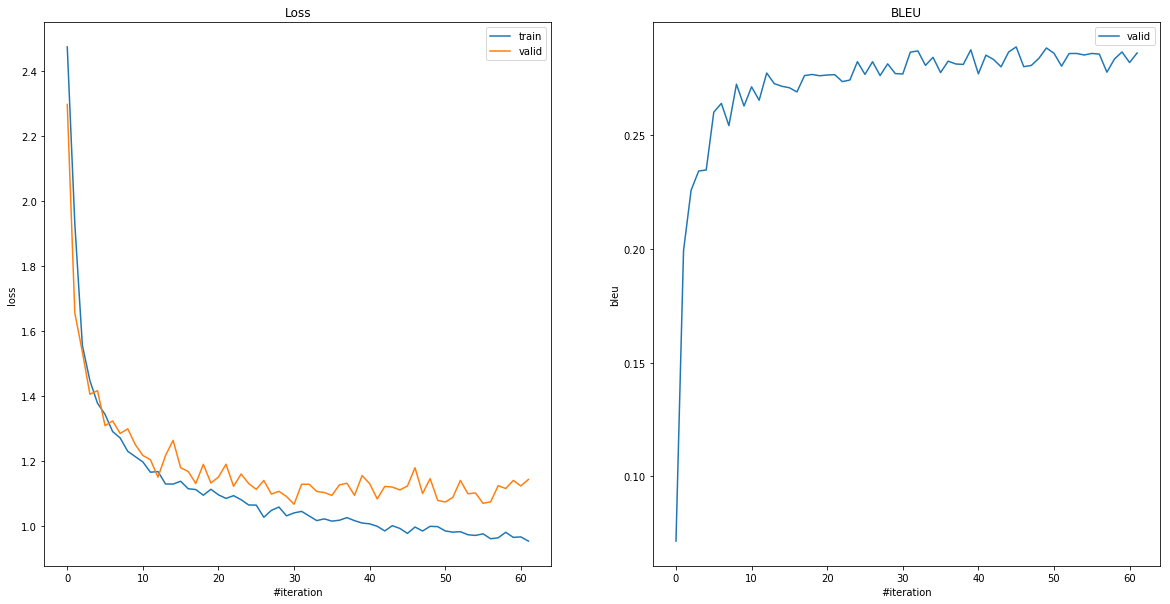

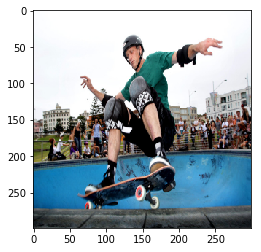

a man is doing a trick on a skateboard .
a skateboarder doing a trick on a ramp .
a man riding a skateboard on top of a ramp .
a man is doing a trick on a skateboard .
a man riding a skateboard on a ramp .
a man on a skateboard doing a trick .
a man riding a skateboard on top of a cement ramp .
a skateboarder doing a trick on a ramp .
a man riding a skateboard on top of a ramp .
a skateboarder doing a trick on a ramp .


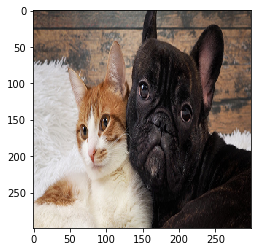

a cat sitting on a chair with a book .
a cat sitting on a bed with a book in its mouth .
a cat sitting on a couch next to a laptop .
a cat laying on a bed with a book on its head .
a cat is sitting on a bench in the grass .
a cat sitting on a bed with a book on the ground .
a cat sitting on a chair with a book on the floor
a cat sitting on a chair next to a car .
a cat sitting on a bed with a book .
a cat is sitting on a wooden bench .


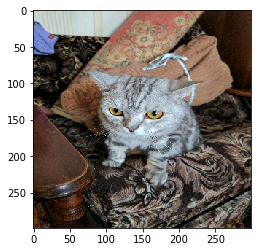

a cat laying on a bed next to a chair .
a cat laying on a chair next to a chair .
a cat is sitting on a chair with a remote control
a cat sitting on a chair with a book on top .
a cat laying on a chair with a book on a table .
a cat sitting on a chair with a book .
a cat sitting on a chair with a cat on it .
a cat is sitting on a chair in a room .
a cat sitting on a chair with a book on the floor .
a cat sitting on top of a chair next to a chair .


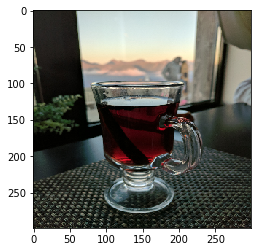

a glass of wine and a glass of wine .
a glass of wine and a glass of wine .
a glass of wine and a glass of wine
a glass of wine is sitting on a table .
a glass of wine is next to a glass of wine .
a glass of wine and a bottle of wine
a glass of wine and a glass of wine
a glass of wine is next to a glass of wine .
a glass of wine sitting on a table next to a bottle of wine .
a glass of wine and a glass of wine


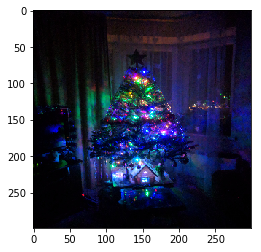

a christmas tree and a christmas tree with flowers
a christmas tree and a christmas tree in a room
a christmas tree and a christmas tree in a room
a christmas tree and a christmas tree in a room
a christmas tree sitting on top of a christmas tree .
a christmas tree and a christmas tree in a room .
a christmas tree with a christmas tree in front of it .
a christmas tree and a christmas tree in a living room
a christmas tree and a christmas tree in a room
a christmas tree with flowers on it


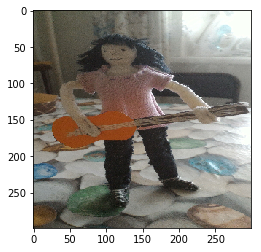

a woman sitting on a bench with a book .
a woman sitting on a bench with a book .
a woman sitting on a bench with a book .
a woman is sitting on a bench with a guitar .
a woman is sitting on a bench with a bag on her head .
a woman sitting on a bench with a laptop .
a woman is sitting on a bench with a guitar .
a woman is sitting on a bench with a bag on her head .
a woman is sitting on a bench with a book .
a man with a hat and a snowboard on a street .


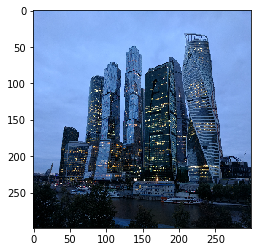

a large building with a large clock tower .
a large building with a clock tower in the middle of the street .
a tall building with a clock on the front of it .
a large building with a clock tower and a building .
a large building with a large clock tower in the middle .
a large building with a clock tower on the side of it .
a large building with a large tower with a clock on it .
a large building with a clock tower on the side .
a large building with a clock tower in the middle .
a large building with a large clock tower in the middle of the street .


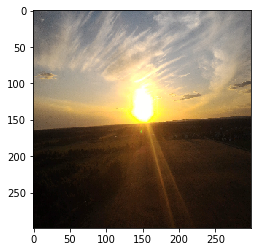

a view from a plane on a foggy day .
a view of a beach with a plane in the water .
a view from a plane on the beach .
a view of a beach from a plane with mountains in the background .
a view from a window of a mountain with a view of the ocean .
a view from a plane in the mountains .
a view from a plane on a beach overlooking the ocean .
a view from a plane over a body of water .
a view from a window of a mountain with a view of the ocean .
a view from a window overlooking a body of water .


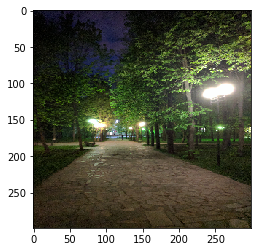

a street with a lot of cars and a lot of trees .
a train going down the street in the middle of the day .
a red bench sitting on a sidewalk next to a street .
a street with a lot of cars and trees .
a street with a bunch of cars and cars on it
a bench on a city street with a building in the background .
a street with a bunch of cars parked on it
a street with a bench and a street sign .
a street with a bunch of cars in the middle of the street
a red bench sitting in the middle of a street .


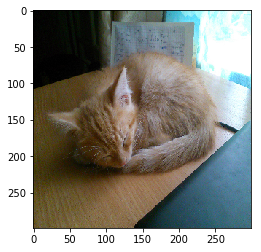

a cat laying on a chair with a remote control .
a cat laying on a bed with a remote control .
a cat laying on a bed with a remote control .
a cat laying on a chair with a remote control .
a cat laying on a couch with a remote control .
a cat laying on a chair with a remote control .
a cat laying on a bed with a remote control .
a cat laying on a bed with a remote control .
a cat laying on a bed with a remote control .
a cat laying on a bed with a remote control .


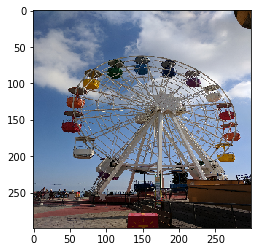

a man is standing in front of a large building .
a man is standing in front of a large building with a large clock .
a man is standing in front of a large building .
a man is standing in front of a large building .
a man is standing in front of a large building
a man is standing in front of a building with a kite .
a man is standing in front of a large clock .
a man is standing in front of a large building .
a man is standing in front of a large building .
a man standing in front of a large building with a large clock .


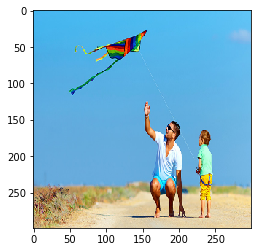

a man is flying a kite on the beach .
a man is flying a kite in the sand .
a man is flying a kite on the beach .
a man is flying a kite in the sand
a man is flying a kite in a park .
a man is flying a kite in the sand .
a man is flying a kite on the beach .
a man is flying a kite in the air .
a man is flying a kite in a park .
a man is flying a kite in the sand .


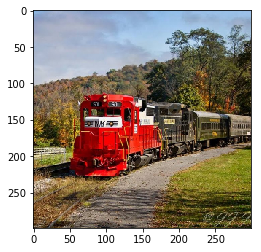

a train is traveling down the tracks in the countryside .
a train is going down the tracks in the countryside .
a train traveling down train tracks near a forest .
a train traveling down tracks next to a forest .
a train traveling down train tracks with trees in the background .
a train is traveling down the tracks in the countryside .
a train is traveling down the tracks in the countryside .
a train is traveling down the tracks by a forest .
a train is traveling down the tracks in the countryside .
a train is traveling down the tracks with trees in the background .


In [25]:
network.load_state_dict(best_on_val_state_dict)
torch.save(network, "baseline_without_concat.model")
plot_metrics({"Loss":{"train": train_losses, "valid": val_losses},
              "BLEU":{"valid": val_bleu}})
show_sample_captions(image_url="https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg")
show_sample_captions(image_url="http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg")
for image_file in os.listdir("images"):
    show_sample_captions(image_path=os.path.join("images", image_file))
show_sample_captions(image_url="http://cdn2.momjunction.com/wp-content/uploads/2016/01/Steps-To-Fly-A-Kite-With-Your-Kid.jpg")
show_sample_captions(image_url="https://yt3.ggpht.com/a-/AJLlDp0Z8RKOktBaSzTGjgzPujPo3HMIokLBdMhNww=s900-mo-c-c0xffffffff-rj-k-no")

## 5-layer LSTM where we concatenate input image features with each lstm input

In [28]:
batch_size = 256  # adjust me
n_epochs = 100  # adjust me
network = CaptionNet(n_tokens)
lr = 0.001
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
train_losses, val_losses, val_bleu, best_on_val_state_dict = train(network, optimizer, n_epochs, batch_size)



Epoch: 0, train loss: 2.5028674602508545, val loss: 2.230738878250122, val_bleu: 0.07967234877026556




Epoch: 1, train loss: 2.0573925971984863, val loss: 1.5773082971572876, val_bleu: 0.17028829076769014




Epoch: 2, train loss: 1.5999571084976196, val loss: 1.5839186906814575, val_bleu: 0.21950156609317378




Epoch: 3, train loss: 1.4981378316879272, val loss: 1.4815467596054077, val_bleu: 0.2387274978005887




Epoch: 4, train loss: 1.4550925493240356, val loss: 1.43145751953125, val_bleu: 0.2391592203041312




Epoch: 5, train loss: 1.3977978229522705, val loss: 1.460493803024292, val_bleu: 0.24261784742678194




Epoch: 6, train loss: 1.337876558303833, val loss: 1.343430995941162, val_bleu: 0.25591768425907735




Epoch: 7, train loss: 1.3163572549819946, val loss: 1.3530763387680054, val_bleu: 0.2544369461374105




Epoch: 8, train loss: 1.3053120374679565, val loss: 1.3531761169433594, val_bleu: 0.26497651538427025




Epoch: 9, train loss: 1.2919490337371826, val loss: 1.2975114583969116, val_bleu: 0.2619853332285297




Epoch: 10, train loss: 1.2723890542984009, val loss: 1.2874085903167725, val_bleu: 0.26364148837392437




Epoch: 11, train loss: 1.246380090713501, val loss: 1.2944409847259521, val_bleu: 0.264208478835128




Epoch: 12, train loss: 1.2408884763717651, val loss: 1.2995884418487549, val_bleu: 0.269072571059545




Epoch: 13, train loss: 1.2522352933883667, val loss: 1.310317873954773, val_bleu: 0.27197998611788926




Epoch: 14, train loss: 1.1912835836410522, val loss: 1.2294352054595947, val_bleu: 0.2698494820381224




Epoch: 15, train loss: 1.206956386566162, val loss: 1.289740800857544, val_bleu: 0.27141997635798




Epoch: 16, train loss: 1.190897822380066, val loss: 1.2577255964279175, val_bleu: 0.2772980628105651




Epoch: 17, train loss: 1.1949381828308105, val loss: 1.2035472393035889, val_bleu: 0.2737508585327315




Epoch: 18, train loss: 1.1802531480789185, val loss: 1.2683236598968506, val_bleu: 0.2833297941720396




Epoch: 19, train loss: 1.1612833738327026, val loss: 1.1698235273361206, val_bleu: 0.28289935943025435




Epoch: 20, train loss: 1.1571249961853027, val loss: 1.1598812341690063, val_bleu: 0.27883602905238813




Epoch: 21, train loss: 1.1468030214309692, val loss: 1.219312310218811, val_bleu: 0.2745253734001212




Epoch: 22, train loss: 1.1454970836639404, val loss: 1.199636697769165, val_bleu: 0.2674006885010898




Epoch: 23, train loss: 1.1572802066802979, val loss: 1.214377522468567, val_bleu: 0.27147296098077445




Epoch: 24, train loss: 1.1231857538223267, val loss: 1.1491881608963013, val_bleu: 0.2783001612559647




Epoch: 25, train loss: 1.1319586038589478, val loss: 1.1903395652770996, val_bleu: 0.2879015076245038




Epoch: 26, train loss: 1.1259657144546509, val loss: 1.1736904382705688, val_bleu: 0.2777339046126449




Epoch: 27, train loss: 1.1225947141647339, val loss: 1.2473610639572144, val_bleu: 0.2793729150595864




Epoch: 28, train loss: 1.126709222793579, val loss: 1.1581902503967285, val_bleu: 0.2778276489276767




Epoch: 29, train loss: 1.1050442457199097, val loss: 1.1938053369522095, val_bleu: 0.2780466968973611




Epoch: 30, train loss: 1.1193689107894897, val loss: 1.1565204858779907, val_bleu: 0.27961758389602553




Epoch: 31, train loss: 1.094635248184204, val loss: 1.1573078632354736, val_bleu: 0.28034753027965653




Epoch: 32, train loss: 1.082768201828003, val loss: 1.197725534439087, val_bleu: 0.2823129678286221




Epoch: 33, train loss: 1.0917882919311523, val loss: 1.1916463375091553, val_bleu: 0.27799054812721485




Epoch: 34, train loss: 1.1062647104263306, val loss: 1.1946728229522705, val_bleu: 0.28365379188028217




Epoch: 35, train loss: 1.104414701461792, val loss: 1.1537179946899414, val_bleu: 0.2850538028719971




Epoch: 36, train loss: 1.0788966417312622, val loss: 1.178974986076355, val_bleu: 0.2840730557580378




Epoch: 37, train loss: 1.0802074670791626, val loss: 1.1874876022338867, val_bleu: 0.28029587440785286




Epoch: 38, train loss: 1.071886420249939, val loss: 1.1190193891525269, val_bleu: 0.28447053411958223




Epoch: 39, train loss: 1.0852630138397217, val loss: 1.158854365348816, val_bleu: 0.281814920837325




Epoch: 40, train loss: 1.0657532215118408, val loss: 1.1423527002334595, val_bleu: 0.28309229756545096




Epoch: 41, train loss: 1.0605381727218628, val loss: 1.112060785293579, val_bleu: 0.2876496133070267
Finished!


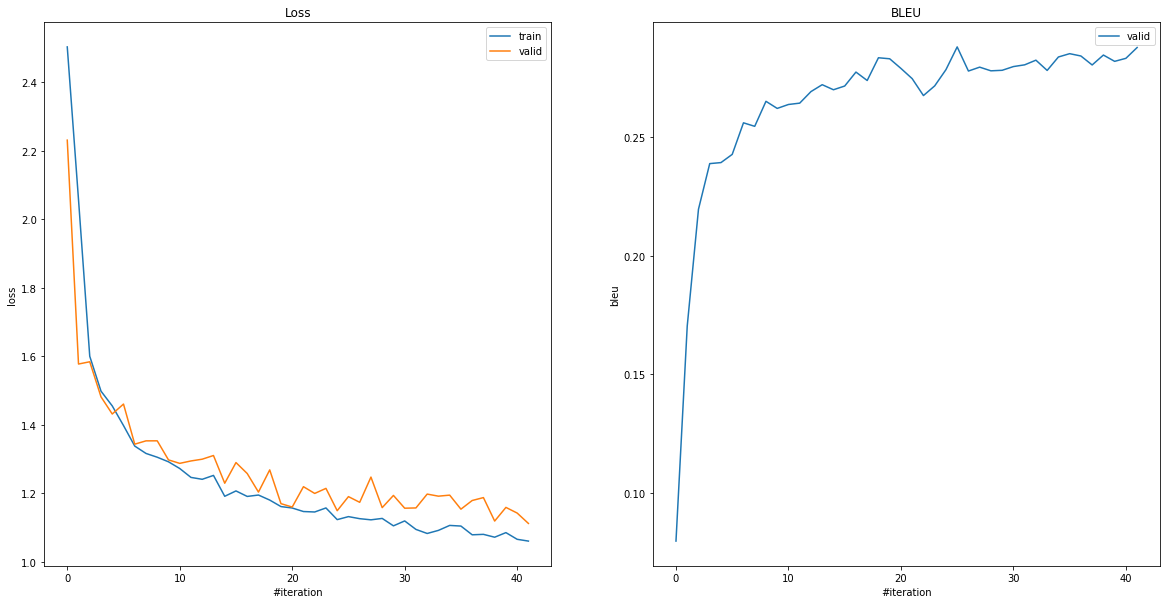

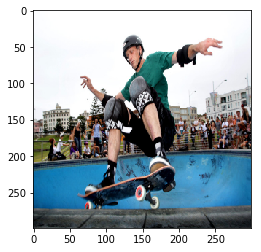

a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a person riding a skateboard on a ramp .
a man on a skateboard jumping down a ramp .
a man jumping in the air while riding a skateboard .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .


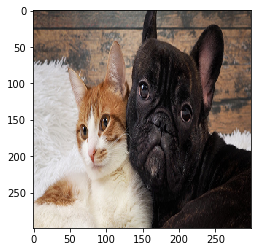

a black and white cat laying on a couch .
a black and white cat laying on a bed .
a black and white cat laying on a bed .
a black and white cat laying on a couch .
a black and white cat laying on top of a couch .
a black and white cat laying on top of a couch .
a black and white cat laying on a bed
a black and white cat sitting on a bed .
a dog that is laying down on a couch .
a black and white cat laying on a bed .


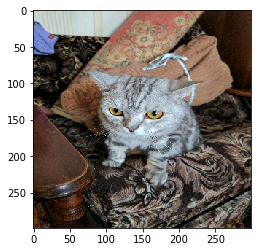

a cat laying on top of a bed next to a book .
a cat laying on a chair next to a book .
a cat sitting on top of a wooden chair .
a cat sitting on top of a bed on a bed .
a cat laying on a bed with a book .
a cat sitting on a bed in a room .
a cat sitting on top of a chair next to a book .
a cat laying on a bed with a book
a cat sitting on a bed next to a book .
a cat sitting on top of a wooden chair .


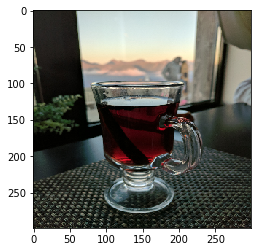

a glass of wine sitting on a table .
a glass of wine sitting on a table .
a glass of wine sitting on top of a table .
a glass of wine sitting on a table .
a glass of wine sitting on a table .
a glass of wine sitting on a table .
a glass of wine and a glass of wine
a glass of wine is sitting on a table .
a glass of wine sitting on a table .
a glass of wine and a glass of wine


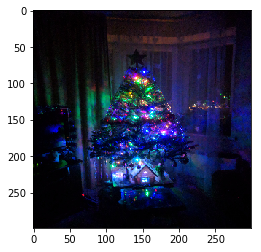

a christmas christmas christmas christmas room with a christmas tree .
a vase with a christmas tree and a clock .
a vase with a vase and a vase .
a christmas christmas vase with a christmas tree .
a vase with a christmas tree and a vase .
a christmas christmas christmas christmas christmas room with a christmas tree .
a christmas christmas christmas christmas christmas room .
a christmas christmas christmas christmas christmas flowers .
a christmas christmas christmas christmas christmas flowers in a room .
a christmas christmas christmas christmas christmas room with a christmas tree .


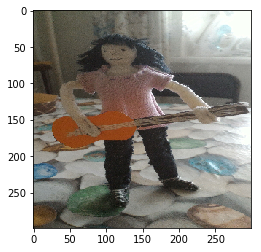

a woman in a red coat and a red jacket and a black umbrella
a woman sitting on a bench with a cell phone .
a woman in a black jacket and a red jacket and a black and white umbrella
a woman sitting on a bench with a cell phone .
a woman in a red coat and a child sitting on a bench .
a woman sitting on a bench holding a skateboard .
a woman sitting on a bench with a cell phone .
a woman holding a skateboard on a skateboard .
a woman with a hat and a skateboard on a bench .
a woman in a red jacket and a red jacket and a black and black umbrella


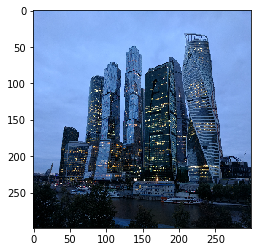

a large clock tower is on the side of a street .
a large clock tower is on the side of a street .
a clock tower is in the middle of a street .
a clock tower is in the middle of a city .
a large clock tower is lit up in the middle of a city .
a large clock tower is lit up in the sky .
a large clock tower is in the middle of a city .
a large clock tower is in the middle of a street .
a large clock tower is in the middle of a street .
a clock tower in the middle of a city .


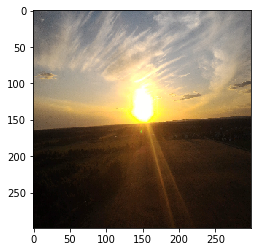

a plane on a beach with a mountain background
a sunset with a plane on it in the sky .
a plane sitting on the side of a beach .
a sunset with a view of a plane on the top of it .
a plane sitting in the middle of a beach .
a plane on a beach near a body of water
a plane on a beach near a body of water .
a plane on a beach with a mountain background .
a plane sitting on a beach near a cloudy sky .
a plane on a beach near a body of water


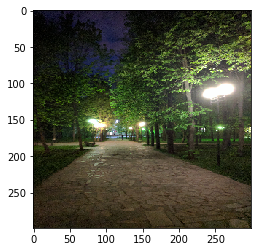

a street with a stop sign and a street .
a street with a stop sign and a street sign .
a street with a stop sign and a street .
a street with a stop sign and a street .
a street with a stop sign and a street sign .
a street with a stop sign and a street sign .
a street with a night lit sign and a street .
a street with a stop sign and a street .
a street with a stop sign and trees .
a street with a stop sign and a street .


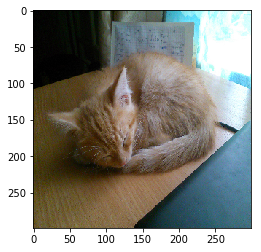

a cat laying on a bed next to a laptop .
a cat laying on top of a laptop computer .
a cat laying on a bed next to a laptop .
a cat laying on a bed next to a laptop .
a cat laying on a bed with a laptop .
a cat laying on a bed next to a laptop .
a cat laying on a bed next to a laptop .
a cat laying on a bed next to a computer .
a cat laying on a bed next to a computer .
a cat laying on a bed next to a computer .


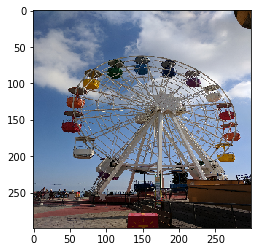

a group of people standing in a field .
a group of people standing in a field .
a group of people standing on top of a large green field .
a group of people standing in the grass .
a group of people standing in the grass with a kite .
a group of people on a beach flying kites .
a group of people standing on top of a large green field .
a group of people are flying kites in the air .
a group of people are flying kites on a beach .
a group of people standing in the grass .


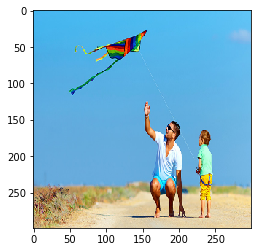

a man flying a kite in the air .
a man flying a kite in the air .
a man is flying a kite in the air .
a man flying a kite in the air .
a man flying a kite on a beach .
a man flying a kite on a beach .
a man flying a kite on a beach .
a man flying a kite in the air .
a man flying a kite on a beach .
a man flying a kite on a beach .


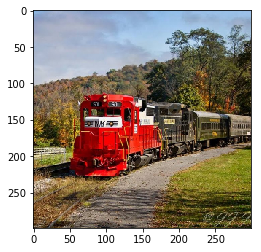

a train traveling down a track in a rural area .
a train traveling down a track near a forest .
a train traveling down a track near a forest .
a train traveling down a track in a rural area .
a train traveling down a track with a mountain background .
a train traveling down a track in a rural area .
a train traveling down a track in a rural area .
a train traveling down a track near a forest .
a train traveling down a track near a forest .
a train engine is coming down the tracks .


In [29]:
network.load_state_dict(best_on_val_state_dict)
torch.save(network, "baseline_with_concat.model")
plot_metrics({"Loss":{"train": train_losses, "valid": val_losses},
              "BLEU":{"valid": val_bleu}})
show_sample_captions(image_url="https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg")
show_sample_captions(image_url="http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg")
for image_file in os.listdir("images"):
    show_sample_captions(image_path=os.path.join("images", image_file))
show_sample_captions(image_url="http://cdn2.momjunction.com/wp-content/uploads/2016/01/Steps-To-Fly-A-Kite-With-Your-Kid.jpg")
show_sample_captions(image_url="https://yt3.ggpht.com/a-/AJLlDp0Z8RKOktBaSzTGjgzPujPo3HMIokLBdMhNww=s900-mo-c-c0xffffffff-rj-k-no")

## 5-layer LSTM with BPE

In [43]:
batch_size = 256  # adjust me
n_epochs = 100  # adjust me
network = CaptionNet(n_tokens, concat_img_features_with_lstm_state=False)
lr = 0.001
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
train_losses, val_losses, val_bleu, best_on_val_state_dict = train(network, optimizer, n_epochs, batch_size)



Epoch: 0, train loss: 2.2664408683776855, val loss: 2.163144826889038, val_bleu: 0.06434081458504459




Epoch: 1, train loss: 1.9278736114501953, val loss: 1.5380940437316895, val_bleu: 0.20530570714386348




Epoch: 2, train loss: 1.4504565000534058, val loss: 1.4178794622421265, val_bleu: 0.23322596521473435




Epoch: 3, train loss: 1.3675544261932373, val loss: 1.3352375030517578, val_bleu: 0.2326671843470634




Epoch: 4, train loss: 1.2927272319793701, val loss: 1.3501245975494385, val_bleu: 0.2479972859332028




Epoch: 5, train loss: 1.2291896343231201, val loss: 1.1998718976974487, val_bleu: 0.2568860540142381




Epoch: 6, train loss: 1.1768133640289307, val loss: 1.173711895942688, val_bleu: 0.26573440565885986




Epoch: 7, train loss: 1.148816466331482, val loss: 1.1472433805465698, val_bleu: 0.2553095387322888




Epoch: 8, train loss: 1.1180628538131714, val loss: 1.1370042562484741, val_bleu: 0.27446463486892864




Epoch: 9, train loss: 1.0836787223815918, val loss: 1.1343110799789429, val_bleu: 0.27115754727162805




Epoch: 10, train loss: 1.0600022077560425, val loss: 1.075186848640442, val_bleu: 0.27446700130147034




Epoch: 11, train loss: 1.0274512767791748, val loss: 1.0603816509246826, val_bleu: 0.27523548274621706




Epoch: 12, train loss: 1.0298651456832886, val loss: 1.0486758947372437, val_bleu: 0.2742925171045245




Epoch: 13, train loss: 1.0058541297912598, val loss: 1.0554581880569458, val_bleu: 0.27899383920187565




Epoch: 14, train loss: 0.9851939082145691, val loss: 1.030031442642212, val_bleu: 0.2739039786366484




Epoch: 15, train loss: 0.9687710404396057, val loss: 0.9771366715431213, val_bleu: 0.27905623746905295




Epoch: 16, train loss: 0.9644226431846619, val loss: 1.0375547409057617, val_bleu: 0.27051187761758444




Epoch: 17, train loss: 0.9527893662452698, val loss: 0.9973217844963074, val_bleu: 0.2889915168379387




Epoch: 18, train loss: 0.9417904615402222, val loss: 0.9927685260772705, val_bleu: 0.27326260731824925




Epoch: 19, train loss: 0.9402458667755127, val loss: 0.9422681927680969, val_bleu: 0.2760467009165924




Epoch: 20, train loss: 0.9269262552261353, val loss: 0.9377439618110657, val_bleu: 0.2806150106568617




Epoch: 21, train loss: 0.9160882234573364, val loss: 0.9387823343276978, val_bleu: 0.2682036047981165




Epoch: 22, train loss: 0.9005411863327026, val loss: 0.9832093119621277, val_bleu: 0.28210120574917297




Epoch: 23, train loss: 0.9047304391860962, val loss: 0.9455116987228394, val_bleu: 0.2828279592310705




Epoch: 24, train loss: 0.9041135311126709, val loss: 0.9137576222419739, val_bleu: 0.2885144843762399




Epoch: 25, train loss: 0.8930429816246033, val loss: 0.8949071764945984, val_bleu: 0.27826838554676875




Epoch: 26, train loss: 0.8947853446006775, val loss: 0.9336682558059692, val_bleu: 0.27815406977361407




Epoch: 27, train loss: 0.8902033567428589, val loss: 0.9643240571022034, val_bleu: 0.28886138355701035




Epoch: 28, train loss: 0.8768272995948792, val loss: 0.8878594040870667, val_bleu: 0.2897064225434711




Epoch: 29, train loss: 0.8634195923805237, val loss: 0.891457736492157, val_bleu: 0.2825528946581332




Epoch: 30, train loss: 0.8479083180427551, val loss: 0.9259244203567505, val_bleu: 0.282733074608854




Epoch: 31, train loss: 0.8581013083457947, val loss: 0.8826388716697693, val_bleu: 0.28274312888150194




Epoch: 32, train loss: 0.8622831106185913, val loss: 0.8775205612182617, val_bleu: 0.28703336327404405




Epoch: 33, train loss: 0.8562300205230713, val loss: 0.9048438668251038, val_bleu: 0.28561353175773896




Epoch: 34, train loss: 0.8454587459564209, val loss: 0.877004086971283, val_bleu: 0.2748727236588229




Epoch: 35, train loss: 0.8515573740005493, val loss: 0.895667552947998, val_bleu: 0.284697545138765




Epoch: 36, train loss: 0.8424411416053772, val loss: 0.8580754995346069, val_bleu: 0.2761893829671719




Epoch: 37, train loss: 0.8315491080284119, val loss: 0.8627889156341553, val_bleu: 0.27890741556905235




Epoch: 38, train loss: 0.8198117613792419, val loss: 0.8888601064682007, val_bleu: 0.2799513687327151




Epoch: 39, train loss: 0.8493925333023071, val loss: 0.8649213314056396, val_bleu: 0.2853679002537327




Epoch: 40, train loss: 0.8274516463279724, val loss: 0.8493351340293884, val_bleu: 0.28133667599640483




Epoch: 41, train loss: 0.8313983082771301, val loss: 0.9076464772224426, val_bleu: 0.280672227155695




Epoch: 42, train loss: 0.825197160243988, val loss: 0.8774038553237915, val_bleu: 0.2841018224694909




Epoch: 43, train loss: 0.8215340971946716, val loss: 0.8715286254882812, val_bleu: 0.28037597105287715




Epoch: 44, train loss: 0.822380781173706, val loss: 0.8432648181915283, val_bleu: 0.27431323585214257
Finished!


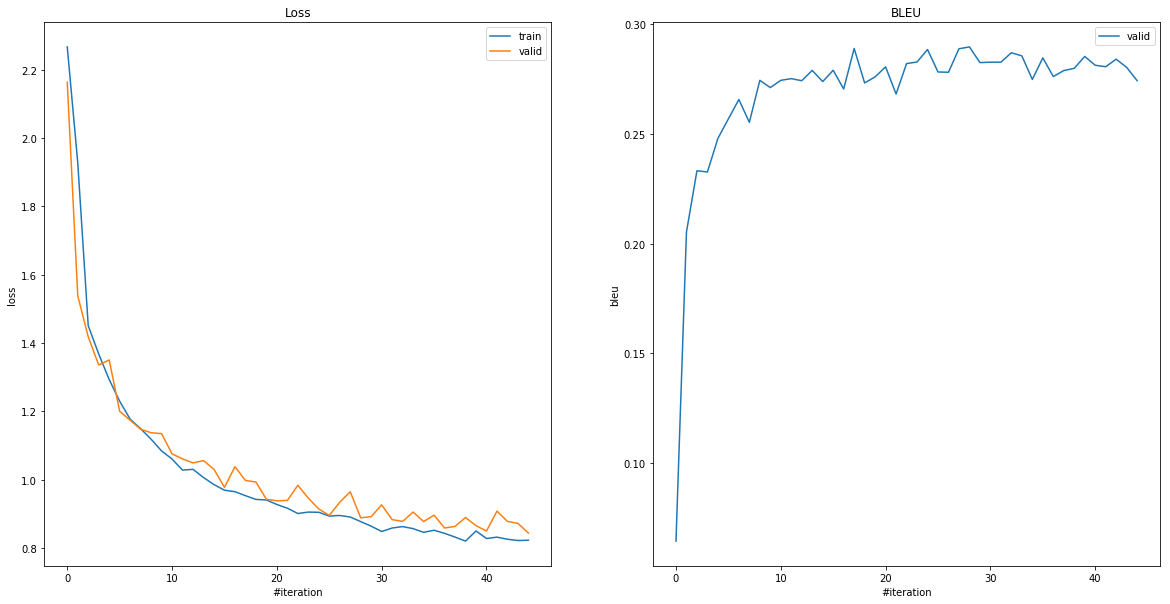

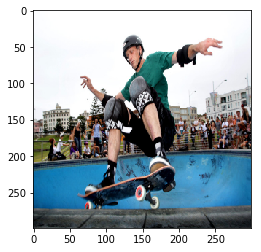

a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man doing a trick on a skateboard .
a man riding a skateboard on top of a ramp .
a man riding a skateboard down a steel ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a skateboarder is doing a trick on a ramp .
a man riding a skateboard on top of a ramp .


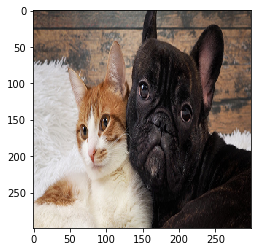

a black and white cat sitting on a wooden bench .
a black and white cat sitting on a blanket .
a black and white cat sitting on a leash .
a black and white cat sitting on a leash .
a black and white cat laying on a leash .
a black and white cat sitting on a leash .
a black and white cat laying on a leash .
a black and white cat sitting on top of a wooden field .
a black and white cat sitting on a bed .
a black and white cat sitting on a bed .


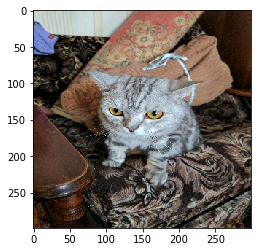

a cat sitting on a chair with a hat .
a cat that is sitting on a chair .
a cat laying on a couch next to a white suitcase .
a cat is sitting on a bed with a cat on it .
a cat sitting on a couch in a room .
a cat laying on a couch next to a table .
a cat is sitting on a couch next to a laptop .
a cat laying on a bed with a remote .
a cat sitting on top of a couch next to a bed .
a cat laying on top of a bed next to a bed .


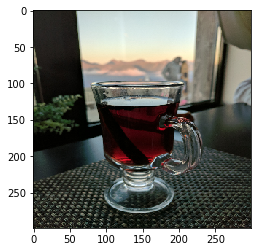

a glass of wine and a glass of wine .
a glass of wine and a glass of wine .
a glass of wine and a glass of wine .
a glass of wine and a glass of wine .
a glass of wine and a glass of wine .
a glass of wine and a glass of wine .
a glass of wine and a glass of wine .
a glass of wine and a glass of wine .
a glass of wine and a glass of wine .
a glass of wine and a glass of wine .


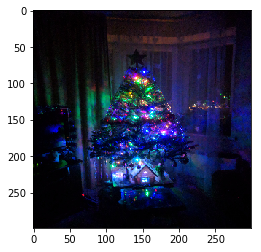

a vase filled with flowers and a vase of flowers .
a vase filled with lots of flowers and flowers .
a table with a vase of flowers and a vase of flowers .
a vase filled with lots of flowers and a vase of flowers .
a vase filled with lots of flowers and a vase .
a vase filled with lots of flowers and a vase .
a vase filled with flowers and a vase of flowers .
a vase filled with lots of flowers and a vase .
a vase filled with flowers and a table .
a vase filled with lots of flowers and a vase of flowers .


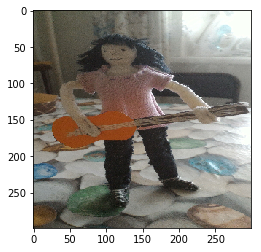

a woman sitting on a bench with a cat .
a woman sitting on a bench with a cat .
a woman sitting on a bench with a cat .
a woman sitting on a bench with a cat .
a woman is sitting on a bench with a bat .
a woman sitting on a bench with a dog .
a woman is sitting on a bench with a cat .
a woman is sitting on a bench with a cat .
a woman sitting on a bench with a cat .
a woman is sitting on a bench with a bat .


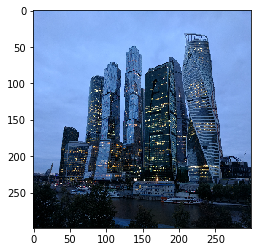

a large clock tower sitting on top of a building .
a large building with a clock on it
a large building with a clock on it .
a large tall building with a clock on it .
a large tall building with a clock on it .
a large tall building with a clock on it .
a large building with a clock on it
a large building with a clock on it .
a large tall building with a clock on it .
a large tall building with a clock on it .


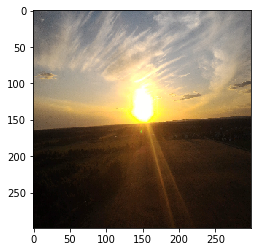

a plane is flying over a mountain and mountains .
a plane is sitting on the ground in the mountains .
a plane is sitting on the side of the road .
a plane sitting on a beach next to a mountain .
a plane is flying over a mountain and mountains .
a plane is parked in a field near a mountain .
a plane is flying over a mountain and a mountain .
a plane sitting on a beach next to a mountain .
a view of a plane in the middle of the ocean .
a plane is sitting on the beach near a mountain .


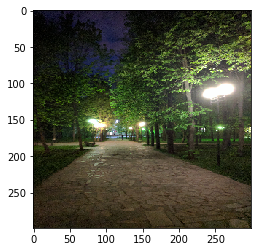

a street with a red and white fire hydrant .
a red fire hydrant on a city street .
a street with a red and white sign
a red fire hydrant on a street with a red light .
a street with a red stop sign and a street sign .
a street with a red and white fire hydrant .
a street with a red and white traffic sign .
a red stop sign sitting on a sidewalk next to a tree .
a red fire hydrant on a sidewalk next to a tree .
a red and white fire hydrant on a street .


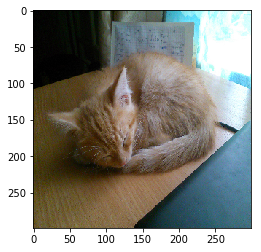

a cat is laying on a couch next to a laptop .
a cat laying on a couch next to a remote .
a cat laying on a couch next to a remote .
a cat laying on a couch next to a remote .
a cat laying on a couch next to a remote .
a cat laying on a couch next to a laptop .
a cat laying on a couch next to a remote .
a cat laying on a couch next to a remote .
a cat laying on a couch next to a remote .
a cat laying on a couch next to a remote .


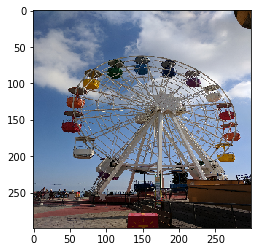

a group of people standing around a large plane .
a group of people standing next to a large plane .
a group of people standing next to a large plane .
a group of people standing around a large plane .
a large airplane with a large clock on it .
a group of people standing around a large plane .
a large plane is parked on a runway .
a man standing on a field with a kite .
a group of people standing next to a large plane .
a group of people standing next to a large plane .


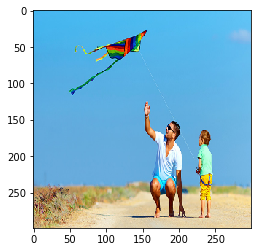

a man is flying a kite on a beach .
a man flying a kite on a beach .
a man is flying a kite in the air .
a man is flying a kite on a beach .
a man is flying a kite on a beach .
a man holding a kite in the air .
a man is flying a kite on a beach .
a man is flying a kite on a beach .
a man flying a kite on a beach .
a man is flying a kite on a beach .


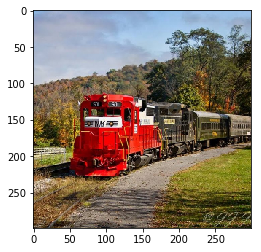

a red train is traveling down a track .
a red train is parked on the tracks .
a red train is traveling down the tracks .
a red and white train traveling down train tracks .
a red train is traveling down a track .
a red train is traveling down a track .
a red train is traveling down a track .
a red train is traveling down the tracks .
a red train is traveling down a track .
a red train is traveling down the tracks .


In [44]:
network.load_state_dict(best_on_val_state_dict)
torch.save(network, "bpe_baseline_without_concat.model")
plot_metrics({"Loss":{"train": train_losses, "valid": val_losses},
              "BLEU":{"valid": val_bleu}})
show_sample_captions(image_url="https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg")
show_sample_captions(image_url="http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg")
for image_file in os.listdir("images"):
    show_sample_captions(image_path=os.path.join("images", image_file))
show_sample_captions(image_url="http://cdn2.momjunction.com/wp-content/uploads/2016/01/Steps-To-Fly-A-Kite-With-Your-Kid.jpg")
show_sample_captions(image_url="https://yt3.ggpht.com/a-/AJLlDp0Z8RKOktBaSzTGjgzPujPo3HMIokLBdMhNww=s900-mo-c-c0xffffffff-rj-k-no")

## 5-layer LSTM with BPE where we concat image features with lstm inputs

In [45]:
batch_size = 256  # adjust me
n_epochs = 100  # adjust me
network = CaptionNet(n_tokens)
lr = 0.001
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
train_losses, val_losses, val_bleu, best_on_val_state_dict = train(network, optimizer, n_epochs, batch_size)



Epoch: 0, train loss: 2.1747148036956787, val loss: 1.8451770544052124, val_bleu: 0.06064632305956528




Epoch: 1, train loss: 1.6462699174880981, val loss: 1.5532939434051514, val_bleu: 0.18573658575927127




Epoch: 2, train loss: 1.4271966218948364, val loss: 1.4016879796981812, val_bleu: 0.19152292066130072




Epoch: 3, train loss: 1.3807549476623535, val loss: 1.3832141160964966, val_bleu: 0.2144778313963452




Epoch: 4, train loss: 1.325496792793274, val loss: 1.3775012493133545, val_bleu: 0.24713661970071102




Epoch: 5, train loss: 1.3063390254974365, val loss: 1.278131365776062, val_bleu: 0.25853894954318735




Epoch: 6, train loss: 1.2704492807388306, val loss: 1.2497293949127197, val_bleu: 0.25824409354424793




Epoch: 7, train loss: 1.2412177324295044, val loss: 1.2632659673690796, val_bleu: 0.26117459514766594




Epoch: 8, train loss: 1.2263450622558594, val loss: 1.2460373640060425, val_bleu: 0.2625769610302834




Epoch: 9, train loss: 1.2121655941009521, val loss: 1.2182925939559937, val_bleu: 0.26671644640206515




Epoch: 10, train loss: 1.1741325855255127, val loss: 1.1774318218231201, val_bleu: 0.26386693916318743




Epoch: 11, train loss: 1.1887452602386475, val loss: 1.2041617631912231, val_bleu: 0.2676031307508388




Epoch: 12, train loss: 1.15604567527771, val loss: 1.1746987104415894, val_bleu: 0.2679838897488253




Epoch: 13, train loss: 1.1725013256072998, val loss: 1.1596790552139282, val_bleu: 0.27618724638982484




Epoch: 14, train loss: 1.144640564918518, val loss: 1.198888897895813, val_bleu: 0.26865693700072596




Epoch: 15, train loss: 1.1201910972595215, val loss: 1.1751679182052612, val_bleu: 0.27802486011190713




Epoch: 16, train loss: 1.1060744524002075, val loss: 1.0928900241851807, val_bleu: 0.2711237504989109




Epoch: 17, train loss: 1.1141245365142822, val loss: 1.108034610748291, val_bleu: 0.2759723855064489




Epoch: 18, train loss: 1.0852134227752686, val loss: 1.0865881443023682, val_bleu: 0.2725842058282109




Epoch: 19, train loss: 1.0827094316482544, val loss: 1.119842290878296, val_bleu: 0.2724443097547284




Epoch: 20, train loss: 1.0702838897705078, val loss: 1.1040990352630615, val_bleu: 0.2761943494537045




Epoch: 21, train loss: 1.0673569440841675, val loss: 1.0257495641708374, val_bleu: 0.2770384357163388




Epoch: 22, train loss: 1.0150151252746582, val loss: 1.1076464653015137, val_bleu: 0.276163488505453




Epoch: 23, train loss: 1.0288716554641724, val loss: 1.0717693567276, val_bleu: 0.27839475536774205




Epoch: 24, train loss: 1.0158617496490479, val loss: 1.0635489225387573, val_bleu: 0.2871396750087238




Epoch: 25, train loss: 0.9833290576934814, val loss: 1.026216983795166, val_bleu: 0.2751051721344813




Epoch: 26, train loss: 0.9978253245353699, val loss: 1.055163025856018, val_bleu: 0.27680105606836153




Epoch: 27, train loss: 0.993754506111145, val loss: 1.018008828163147, val_bleu: 0.2777077228813657




Epoch: 28, train loss: 0.9789890646934509, val loss: 1.0614157915115356, val_bleu: 0.2784474779857151




Epoch: 29, train loss: 0.989630401134491, val loss: 1.0083093643188477, val_bleu: 0.27754153123010517




Epoch: 30, train loss: 0.9619036316871643, val loss: 0.987682580947876, val_bleu: 0.27416772648640153




Epoch: 31, train loss: 0.9542696475982666, val loss: 1.0198642015457153, val_bleu: 0.27966708685475355




Epoch: 32, train loss: 0.9341697692871094, val loss: 0.9776313304901123, val_bleu: 0.2804441036411946




Epoch: 33, train loss: 0.9494066834449768, val loss: 0.9547752737998962, val_bleu: 0.27736505040104126




Epoch: 34, train loss: 0.9387158155441284, val loss: 0.957053005695343, val_bleu: 0.28253433518796756




Epoch: 35, train loss: 0.9050149917602539, val loss: 0.9411887526512146, val_bleu: 0.28296462606454226




Epoch: 36, train loss: 0.9088256359100342, val loss: 0.9517371654510498, val_bleu: 0.27404690418029515




Epoch: 37, train loss: 0.9249149560928345, val loss: 0.9721406102180481, val_bleu: 0.2811929755416067




Epoch: 38, train loss: 0.9251841306686401, val loss: 0.9413203001022339, val_bleu: 0.2755872465181706




Epoch: 39, train loss: 0.923897385597229, val loss: 0.9726751446723938, val_bleu: 0.27744250209668014




Epoch: 40, train loss: 0.9024296402931213, val loss: 0.9376736879348755, val_bleu: 0.2745650730521753
Finished!


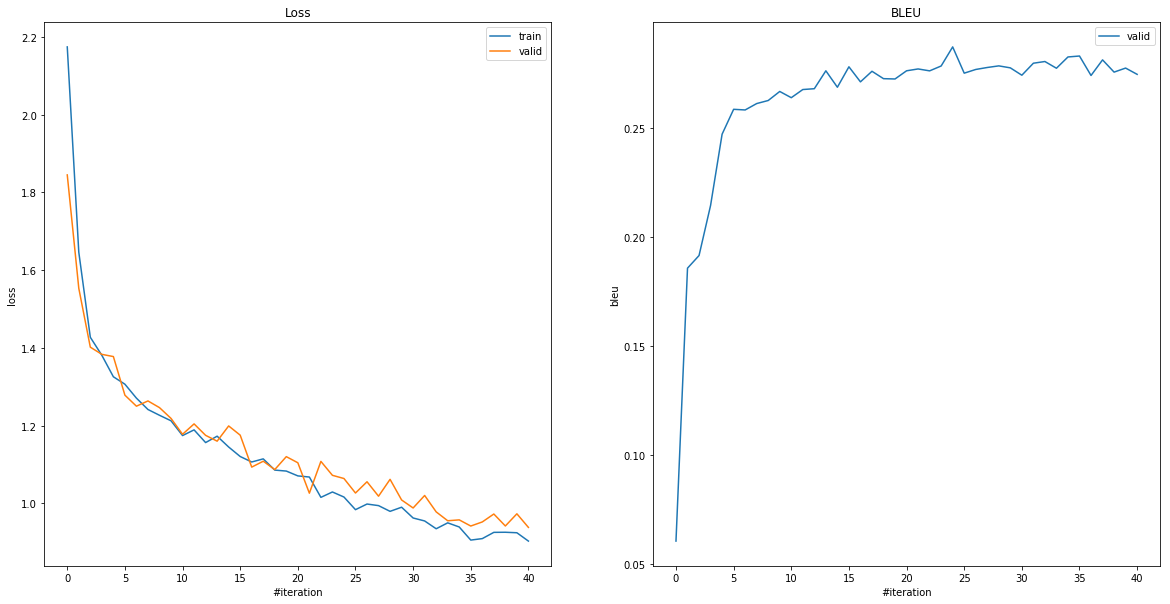

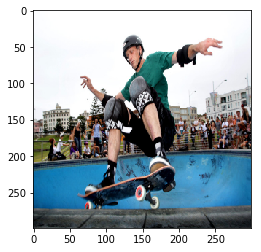

a man is riding a skateboard on a skate park .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man on a skateboard jumping over a ramp .
a man riding a skateboard on a skateboard .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man on a skateboard doing a trick on a skateboard .
a man on a skateboard jumping over a ramp .


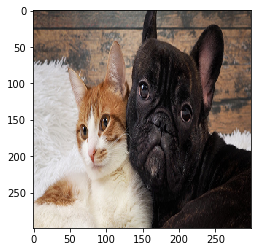

a cat is sitting on a couch with a cat .
a cat is sitting on the floor with a cat .
a cat is sitting on a couch with a cat .
a cat is laying on a couch with a cat .
a cat is sitting on a couch with a cat .
a cat is shown with a black cat .
a cat is sitting on a couch with a cat .
a cat is laying on a couch with a cat .
a cat is sitting on the floor next to a red chair .
a cat is laying on the floor with a cat .


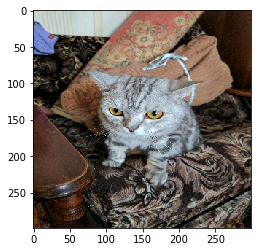

a cat laying on a chair in a room .
a cat is sitting on a chair next to a suitcase .
a cat is laying on a chair in a room .
a cat is laying on a chair in a room .
a cat laying on the floor next to a suitcase .
a cat is laying on a chair in a room .
a cat laying on a chair in front of a window .
a cat is laying on a chair in a room .
a cat is sitting on a chair with a cat .
a cat laying on a chair in a room .


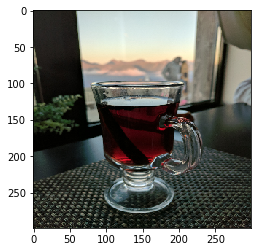

a glass of wine sitting on a table .
a glass of wine and a glass of wine
a glass of wine sitting on a table .
a glass of wine sitting on a table .
a glass of wine sitting on a table .
a glass of wine sitting next to a cup of wine .
a glass of wine and a glass of wine .
a glass of wine and a glass of wine
a glass of wine sitting on a table .
a glass of wine sitting on a table .


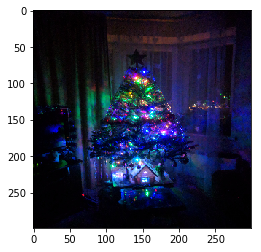

a large table with a bunch of flowers and a clock .
a large table with a bunch of flowers and a clock
a large teddy bear sitting in a chair .
a large table with a large flower covered in front of a window .
a large teddy bear sitting in front of a window .
a large table with a bunch of flowers sitting on it .
a large table with a large flower and a clock .
a large teddy bear sitting in a room .
a large teddy bear sitting in a room .
a large table with a bunch of flowers and a vase of flowers .


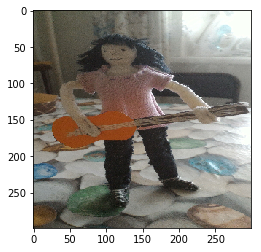

a woman holding a pair of bananas in a garol .
a woman holding a pair of bananas in a room .
a woman holding a sany and a woman on a bench .
a woman is holding a pair of bananas .
a woman is holding a cell phone and a woman .
a woman is holding a cell phone and holding a cell case .
a woman holding a cell phone while holding a teddy bear .
a woman holding a cell phone while holding a cell phone .
a woman is holding a teddy bear .
a woman is holding a cell case and a woman .


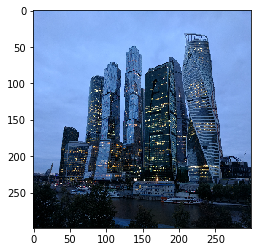

a large clock tower with a clock on the top .
a large clock tower with a clock on it .
a large clock tower with a clock on it .
a clock tower is in the middle of a city .
a large clock tower with a clock tower .
a large clock tower with a clock on it .
a clock tower with a clock on it .
a large clock tower with a clock tower .
a large clock tower with a clock on top of it .
a large clock tower with a clock tower .


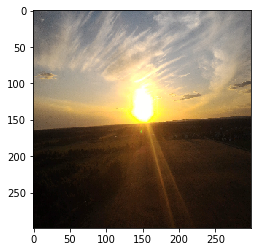

a view of a plane in the sky
a view of a plane in the sky
a view of a mountain with a sky mounted on the ground .
a view of a mountain that is flying a kite .
a view of a plane in the sky .
a view of a mountain in the air .
a view of a plane that is on the beach .
a view of a mountain with a mountain in the background .
a view of a mountain with a mountain on the top of it .
a view of a mountain with a sky of a mountain in the sky .


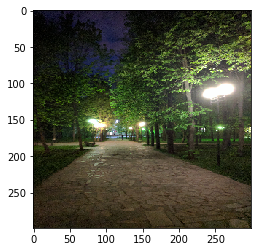

a street with a street light and a street sign
a street with a street sign and a street sign .
a street with a street sign and a street sign
a street with a tree and a tree on the side of the road .
a street with a bench and a tree in the background
a street with a street sign and a tree .
a street with a street light and a street sign
a street with a street sign and a street
a street with a street sign and a tree
a street with a street sign and a street sign .


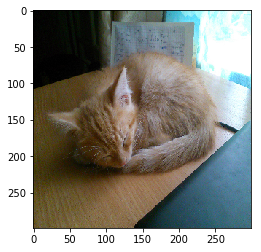

a cat is laying on the floor next to a remote control .
a cat is sitting on a desk with a remote control .
a cat laying on a couch with a remote control .
a cat is laying on a couch with a remote control .
a cat is laying on a desk next to a computer .
a cat is sitting on a desk with a remote control .
a cat laying on a couch next to a remote control .
a cat is laying on a chair with a remote control .
a cat is laying on a couch with a remote control .
a cat laying on a couch with a remote control .


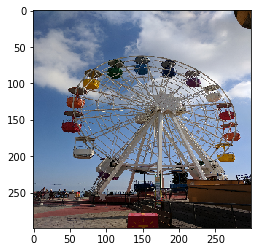

a man is holding a large umbrella in the air .
a group of people standing in front of a building .
a group of people standing in front of a building .
a group of people standing on top of a green field .
a man is standing in front of a large building .
a group of people standing in front of a building .
a group of people standing in front of a building .
a group of people standing in front of a building .
a group of people standing in front of a building .
a group of people standing in front of a building .


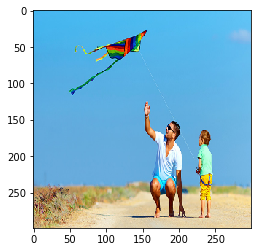

a man in a blue shirt is flying a kite .
a man in a blue shirt is flying a kite .
a man is flying a kite in the air .
a man is flying a kite in the air .
a man in a blue shirt is flying a kite .
a man in a blue shirt is playing a kite .
a man is flying a kite in the air .
a man is flying a kite in the air .
a man is flying a kite in the air .
a man is flying a kite in the air .


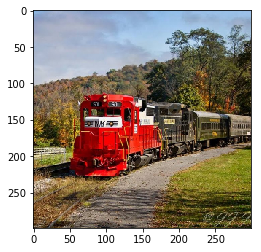

a red train engine with a red and white train .
a red train engine is going down the tracks .
a red train engine with a red and black train .
a train traveling down the tracks near a cloudy sky .
a train engine with a train on the tracks .
a red train engine is going down the tracks .
a red train engine with a train on it .
a red train traveling down the tracks next to a forest .
a red train traveling down a track next to a forest .
a red train engine is parked on the tracks


In [51]:
network.load_state_dict(best_on_val_state_dict)
torch.save(network, "bpe_baseline_with_concat.model")
plot_metrics({"Loss":{"train": train_losses, "valid": val_losses},
              "BLEU":{"valid": val_bleu}})
show_sample_captions(image_url="https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg")
show_sample_captions(image_url="http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg")
for image_file in os.listdir("images"):
    show_sample_captions(image_path=os.path.join("images", image_file))
show_sample_captions(image_url="http://cdn2.momjunction.com/wp-content/uploads/2016/01/Steps-To-Fly-A-Kite-With-Your-Kid.jpg")
show_sample_captions(image_url="https://yt3.ggpht.com/a-/AJLlDp0Z8RKOktBaSzTGjgzPujPo3HMIokLBdMhNww=s900-mo-c-c0xffffffff-rj-k-no")

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563